In [2]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
import seaborn as sn
from pprint import pprint

import matplotlib
from matplotlib import pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Classificacao de Pulsos LZ

## Suporte de cada classe

In [3]:
#Grava os dados numa Dataframe
dataframe = pd.read_csv("../Data_Challenge_1.csv", header=0)


#Mostra a representatividade de cada class
dataframe['pulseClass'].value_counts(sort=True)

3    692863
2    285119
1     22018
Name: pulseClass, dtype: int64

In [4]:
# Dividir os dados em Treino e Teste (80%//20%)

train_data, test_data, train_lbl, test_lbl = train_test_split(dataframe.drop(["pulseClass"], axis=1), dataframe["pulseClass"], test_size=1/5.0, random_state=0) 

## Normalizacao dos dados

In [5]:
#Metodo 1
def standardizeData(df):
    # copy the dataframe
    df_std = df.copy()
    
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
    return df_std

dataframe_std = standardizeData(dataframe.drop(["pulseClass"], axis=1))

In [6]:
#Metodo 2

scaler = StandardScaler()
scaler.fit(train_data)

train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

## Estudo da correlacao dos dados

In [7]:
w_x_axis = widgets.Dropdown(
    options=list(dataframe.columns[1:]),
    description='X axis',
    disabled=False,
)

w_y_axis = widgets.Dropdown(
    options=list(dataframe.columns[1:]),
    description='Y axis',
    disabled=False,
)

display(w_x_axis)
display(w_y_axis)

Dropdown(description='X axis', options=('pA', 'pF50', 'TBA', 'pH', 'pL', 'pL90', 'aft5', 'aft25', 'aft50', 'af…

Dropdown(description='Y axis', options=('pA', 'pF50', 'TBA', 'pH', 'pL', 'pL90', 'aft5', 'aft25', 'aft50', 'af…

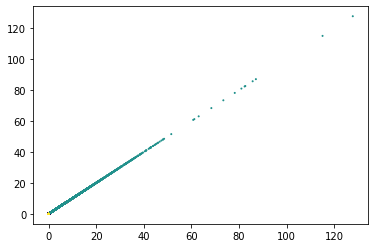

In [8]:
x = dataframe_std[w_x_axis.value].values
y = dataframe_std[w_y_axis.value].values
label = dataframe["pulseClass"].values

plt.scatter(x, y, s=1, c=label)

#plt.hist2d(np.log10(x), y, bins=(np.linspace(-4.5,7.5,150), np.linspace(-0.2,1.5,150)), cmap=plt.cm.viridis)

## Selecao e reducao de Features

### Por correlacao

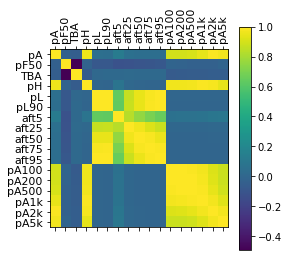

In [9]:
plt.matshow(dataframe_std.cov())
plt.xticks(range(17),dataframe_std.columns,fontsize=11,rotation=90)
plt.yticks(range(17),dataframe_std.columns,fontsize=11)
plt.colorbar()

A matrix de Covariancia mostra que os aftxx estao altamentre correlacionados entre si, assim como os pAxx. Isto significa que usar pA100 e pA200 nao vai adicionar grande informacao vs usar apenas pA100, por isso podemos ignorar features altamente correlacionadas. Mas em vez de simplesmente ignorar, podemos combinar features e tentar eliminar a correlacao entre elas. E possivel eliminar a dependencia entre os varios pAxx's se dividirmos pela area total do sinal (pA).

ADICIONAR FORMULA EM LATEX

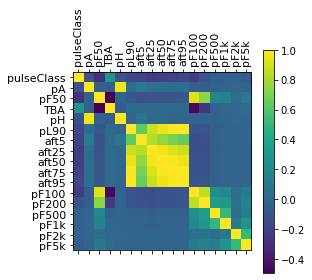

In [10]:
#Eliminar correlacao entre pAxxx

old_feat_names = ["pA100", "pA200", "pA500", "pA1k", "pA2k", "pA5k"]
new_feat_names = ["pF100", "pF200", "pF500", "pF1k", "pF2k", "pF5k"]
new_dataframe = dataframe

for i in range(6):
    
    new_dataframe[new_feat_names[i]] = dataframe[old_feat_names[i]]/dataframe['pA']

new_dataframe_std = standardizeData(new_dataframe.drop(old_feat_names, axis=1))

new_dataframe_std = new_dataframe_std.drop("pL",axis=1)

plt.matshow(new_dataframe_std.cov())
plt.xticks(range(17),new_dataframe_std.columns,fontsize=11,rotation=90)
plt.yticks(range(17),new_dataframe_std.columns,fontsize=11)
plt.colorbar()

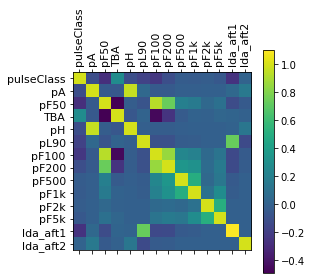

In [11]:
#Combinar os aftxx com LDA

lda = LDA(n_components=2)

lda_afts = lda.fit_transform(new_dataframe_std[["aft5","aft25", "aft50", "aft75", "aft95"]].values, dataframe["pulseClass"].values)

new_dataframe_std = new_dataframe_std.drop(["aft5","aft25", "aft50", "aft75", "aft95"], axis=1)
new_dataframe_std["lda_aft1"] = lda_afts[:,0]
new_dataframe_std["lda_aft2"] = lda_afts[:,1]

plt.matshow(new_dataframe_std.cov())
plt.xticks(range(14),new_dataframe_std.columns,fontsize=11,rotation=90)
plt.yticks(range(14),new_dataframe_std.columns,fontsize=11)
plt.colorbar()

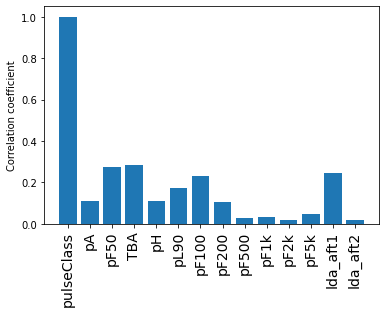

In [12]:
#Feature Reduction metodo 1

temp = new_dataframe_std

plt.bar(temp.columns, temp.corr().abs()["pulseClass"])
plt.xticks(range(temp.shape[1]), temp.columns, fontsize=14, rotation=90)
plt.ylabel("Correlation coefficient")
plt.show()

In [13]:
final_data = new_dataframe_std.drop(["pA", "pH", "pF200", "pF500", "pF1k", "pF2k", "pF5k", "lda_aft2"], axis = 1)

threshold_train_data, threshold_test_data, threshold_train_lbl, threshold_test_lbl = train_test_split(final_data, dataframe["pulseClass"], test_size=1/5.0, random_state=0) 

### PCA Analysis

In [17]:
pca = PCA(.98)
pca.fit(train_data)

pca_train_data = pca.transform(train_data)
pca_test_data = pca.transform(test_data)

pca.n_components_

6

## Random Forests

In [18]:
rf = RandomForestRegressor(random_state = 42)

rf.fit(pca_train_data, train_lbl);

In [19]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    #return accuracy

In [20]:
evaluate(rf, pca_test_data, test_lbl)

Model Performance
Average Error: 0.0166 degrees.
Accuracy = 99.30%.


<AxesSubplot:>

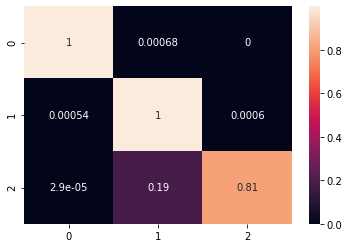

In [30]:
pca_predictions = rf.predict(pca_test_data).astype("int")

conf_matrix = confusion_matrix(test_lbl, pca_predictions)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

sn.heatmap(conf_matrix, annot=True)

In [22]:
print(classification_report(test_lbl, pca_predictions))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00      4388
           2       0.69      1.00      0.81     56898
           3       1.00      0.81      0.90    138714

    accuracy                           0.87    200000
   macro avg       0.89      0.94      0.90    200000
weighted avg       0.91      0.87      0.87    200000



### Hyperparameter

In [23]:
# Numero de arvores na Random Forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 600, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Numero maximo de niveis na arvore
max_depth = [int(x) for x in np.linspace(5, 100, num = 10)]
max_depth.append(None)

# Numero minimo de samples para dividir um nodo
min_samples_split = [2, 5, 10, 15]


min_samples_leaf = [1, 2, 4, 5]

# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,'max_depth': max_depth,'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf,'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 15, 26, 36, 47, 57, 68, 78, 89, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 5],
 'min_samples_split': [2, 5, 10, 15],
 'n_estimators': [10, 75, 141, 206, 272, 337, 403, 468, 534, 600]}


In [24]:
rf1 = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [25]:
#rf_random.fit(pca_train_data, train_lbl)